## Problem Statement

The goal of this project is to predict MLB batter salaries using the Lahman Baseball Database. Although the dataset spans 1871–2024, the analysis is restricted to seasons from 2000–2024 to reflect the modern era of baseball, during which salary structures, free agency, and player valuation are more consistent and comparable.

## Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

In [2]:
people = pd.read_csv(r'C:\Users\jaden\Downloads\lahman\lahman_1871-2024_csv\People.csv')
salaries = pd.read_csv(r'C:\Users\jaden\Downloads\lahman\lahman_1871-2024_csv\Salaries.csv')
batting = pd.read_csv(r'C:\Users\jaden\Downloads\lahman\lahman_1871-2024_csv\Batting.csv')
fielding = pd.read_csv(r'C:\Users\jaden\Downloads\lahman\lahman_1871-2024_csv\Fielding.csv')

In [3]:
df = batting.merge(salaries, on=['playerID','yearID'], how='left')

In [4]:
df = df.merge(fielding, on=['playerID','yearID'], how='left')

In [5]:
df = df.merge(people, on='playerID', how='left')

In [6]:
df = df[df['yearID'] >= 2000]

In [7]:
df.fillna({'G':0, 'PA':0, 'HR':0, 'RBI':0, 'SB':0, 'E':0}, inplace=True)

In [8]:
df['yearID'].min(), df['yearID'].max()

(np.int64(2000), np.int64(2024))

## Data Cleaning

In [9]:
df.drop(columns=['stint_x'], inplace=True)
df = df[df['AB'] > 0]
df.drop(columns=['G_x'], inplace=True)
df.rename(columns={'G_batting': 'G'}, inplace=True)
df.drop(columns=['lgID_x'], inplace=True)

In [10]:
df.isnull().sum().sort_values(ascending=False).head()

ZR            41617
WP            41367
deathState    41198
deathCity     41196
deathYear     41196
dtype: int64

Following data merging, missing values were primarily concentrated among batting-related fields, corresponding to players with no recorded offensive statistics for a given season. These observations were excluded to ensure a consistent modeling population of active batters.

In [11]:
df.columns

Index(['playerID', 'yearID', 'teamID_x', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB_x', 'CS_x', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP',
       'G_old', 'teamID_y', 'lgID_y', 'salary', 'stint_y', 'teamID', 'lgID',
       'POS', 'G_y', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB_y',
       'CS_y', 'ZR', 'ID', 'birthYear', 'birthMonth', 'birthDay', 'birthCity',
       'birthCountry', 'birthState', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast',
       'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'bbrefID',
       'finalGame', 'retroID'],
      dtype='object')

In [12]:
drop_cols = [
    'teamID', 'teamID_x', 'teamID_y',
    'lgID', 'lgID_y', 'stint_y', 'G_old',
    'SH', 'POS', 'PB', 'WP', 'ZR',
    'SB_y', 'CS_y'
]

df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [13]:
df.head

<bound method NDFrame.head of          playerID  yearID     G   AB   R   H  2B  3B  HR   RBI  ...  nameLast  \
1       aardsda01    2006   NaN    2   0   0   0   0   0   0.0  ...   Aardsma   
3       aardsda01    2008   NaN    1   0   0   0   0   0   0.0  ...   Aardsma   
8       aardsda01    2015   NaN    1   0   0   0   0   0   0.0  ...   Aardsma   
76       abadan01    2001   NaN    1   0   0   0   0   0   0.0  ...      Abad   
77       abadan01    2003   NaN   17   1   2   0   0   0   0.0  ...      Abad   
...           ...     ...   ...  ...  ..  ..  ..  ..  ..   ...  ...       ...   
179406  zuninmi01    2019   NaN  266  30  44  10   1   9  32.0  ...    Zunino   
179407  zuninmi01    2020   NaN   75   8  11   4   0   4  10.0  ...    Zunino   
179408  zuninmi01    2021   NaN  333  64  72  11   2  33  62.0  ...    Zunino   
179409  zuninmi01    2022   NaN  115   7  17   3   0   5  16.0  ...    Zunino   
179410  zuninmi01    2023  42.0  124  11  22   7   0   3  11.0  ...    Zunino  

Identifier variables, redundant team and league fields, and non-predictive metadata were removed prior to modeling. The feature set was restricted to offensive performance metrics, playing time, and select biographical attributes relevant to batter salary.

In [14]:
df.isnull().sum().max() == 0

np.False_

In [15]:
df.duplicated().sum()

np.int64(64)

## Feature Engineering

In [16]:
df['age'] = df['yearID'] - df['birthYear']

In [17]:
df['PA'] = (
    df['AB']
    + df['BB']
    + df['HBP']
    + df['SF']
)

In [18]:
df = df[df['PA'] >= 200].copy()

In [19]:
df.columns

Index(['playerID', 'yearID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI',
       'SB_x', 'CS_x', 'BB', 'SO', 'IBB', 'HBP', 'SF', 'GIDP', 'salary', 'G_y',
       'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'ID', 'birthYear', 'birthMonth',
       'birthDay', 'birthCity', 'birthCountry', 'birthState', 'deathYear',
       'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity',
       'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'bats',
       'throws', 'debut', 'bbrefID', 'finalGame', 'retroID', 'age', 'PA'],
      dtype='object')

In [20]:
agg_df = df.groupby(['playerID','yearID']).agg({       
    'AB': 'sum',
    'H': 'sum',
    '2B': 'sum',
    '3B': 'sum',
    'HR': 'sum',
    'RBI': 'sum',      
    'BB': 'sum',
    'HBP': 'sum',
    'SF': 'sum',
    'PA': 'sum',
    'SO': 'sum',
    'SB_x': 'sum',
    'salary': 'last',
    'age': 'last',
    'PO': 'sum',
    'A': 'sum',
    'E': 'sum'
}).reset_index()

In [21]:
# Total bases
agg_df['TB'] = (
    agg_df['H']
    + agg_df['2B']
    + 2 * agg_df['3B']
    + 3 * agg_df['HR']
)

#AVG
agg_df['AVG'] = agg_df['H'] / agg_df['AB']
# OBP
agg_df['OBP'] = (
    agg_df['H'] + agg_df['BB'] + agg_df['HBP']
) / (
    agg_df['AB'] + agg_df['BB'] + agg_df['HBP'] + agg_df['SF']
)

# SLG
agg_df['SLG'] = agg_df['TB'] / agg_df['AB']

# OPS
agg_df['OPS'] = agg_df['OBP'] + agg_df['SLG']

In [22]:
agg_df[['OBP','SLG','OPS']] = agg_df[['OBP','SLG','OPS']].replace([np.inf, -np.inf], np.nan)

In [23]:
agg_df['K_rate'] = agg_df['SO'] / agg_df['PA']
agg_df['BB_rate'] = agg_df['BB'] / agg_df['PA']
agg_df['SB_per_PA'] = agg_df['SB_x'] / agg_df['PA']

In [24]:
agg_df = agg_df[agg_df['salary'] > 0].copy()
agg_df['log_salary'] = np.log(agg_df['salary'])

In [25]:
agg_df.columns

Index(['playerID', 'yearID', 'AB', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'HBP',
       'SF', 'PA', 'SO', 'SB_x', 'salary', 'age', 'PO', 'A', 'E', 'TB', 'AVG',
       'OBP', 'SLG', 'OPS', 'K_rate', 'BB_rate', 'SB_per_PA', 'log_salary'],
      dtype='object')

In [26]:
drop_cols = ['AB','H','2B','3B','BB','HBP','SF','SO','SB_x']
df_model = df.drop(columns=drop_cols)

Used feature engineering to create relevant, straightforward predictors of salary such as age and aggregated offensive metrics like AVG, OPS, walk rate, strikeout rate, etc. A minimum plate appearance filter was introduced to reduce noise and salaries were log-transformed to account for right-skewness. Redundant counting stat columns that are now encompassed by the offensive rates created were dropped to reduce multicollinearity.

The feature set includes offensive rate and counting statistics, plate discipline, playing time, age, base running performance normalized by plate appearances, and fielding metrics. This combination captures both performance quality and skills that influence MLB batter salaries.

## Exploratory Data Analysis

In [27]:
print("Descriptive stats:\n", agg_df.describe())

Descriptive stats:
             yearID           AB            H           2B           3B  \
count  5214.000000  5214.000000  5214.000000  5214.000000  5214.000000   
mean   2007.953778   662.879363   177.675489    35.739931     3.657269   
std       4.909460   402.248746   111.900461    24.278214     4.536793   
min    2000.000000   165.000000    32.000000     2.000000     0.000000   
25%    2004.000000   419.000000   108.000000    20.000000     1.000000   
50%    2008.000000   551.000000   150.000000    30.000000     2.000000   
75%    2012.000000   780.000000   202.750000    43.000000     5.000000   
max    2016.000000  3605.000000   930.000000   220.000000    68.000000   

                HR          RBI           BB          HBP           SF  ...  \
count  5214.000000  5214.000000  5214.000000  5214.000000  5214.000000  ...   
mean     20.613540    86.507863    63.926928     6.817606     5.595896  ...   
std      17.577781    57.512356    45.825106     7.496576     5.084771  ... 

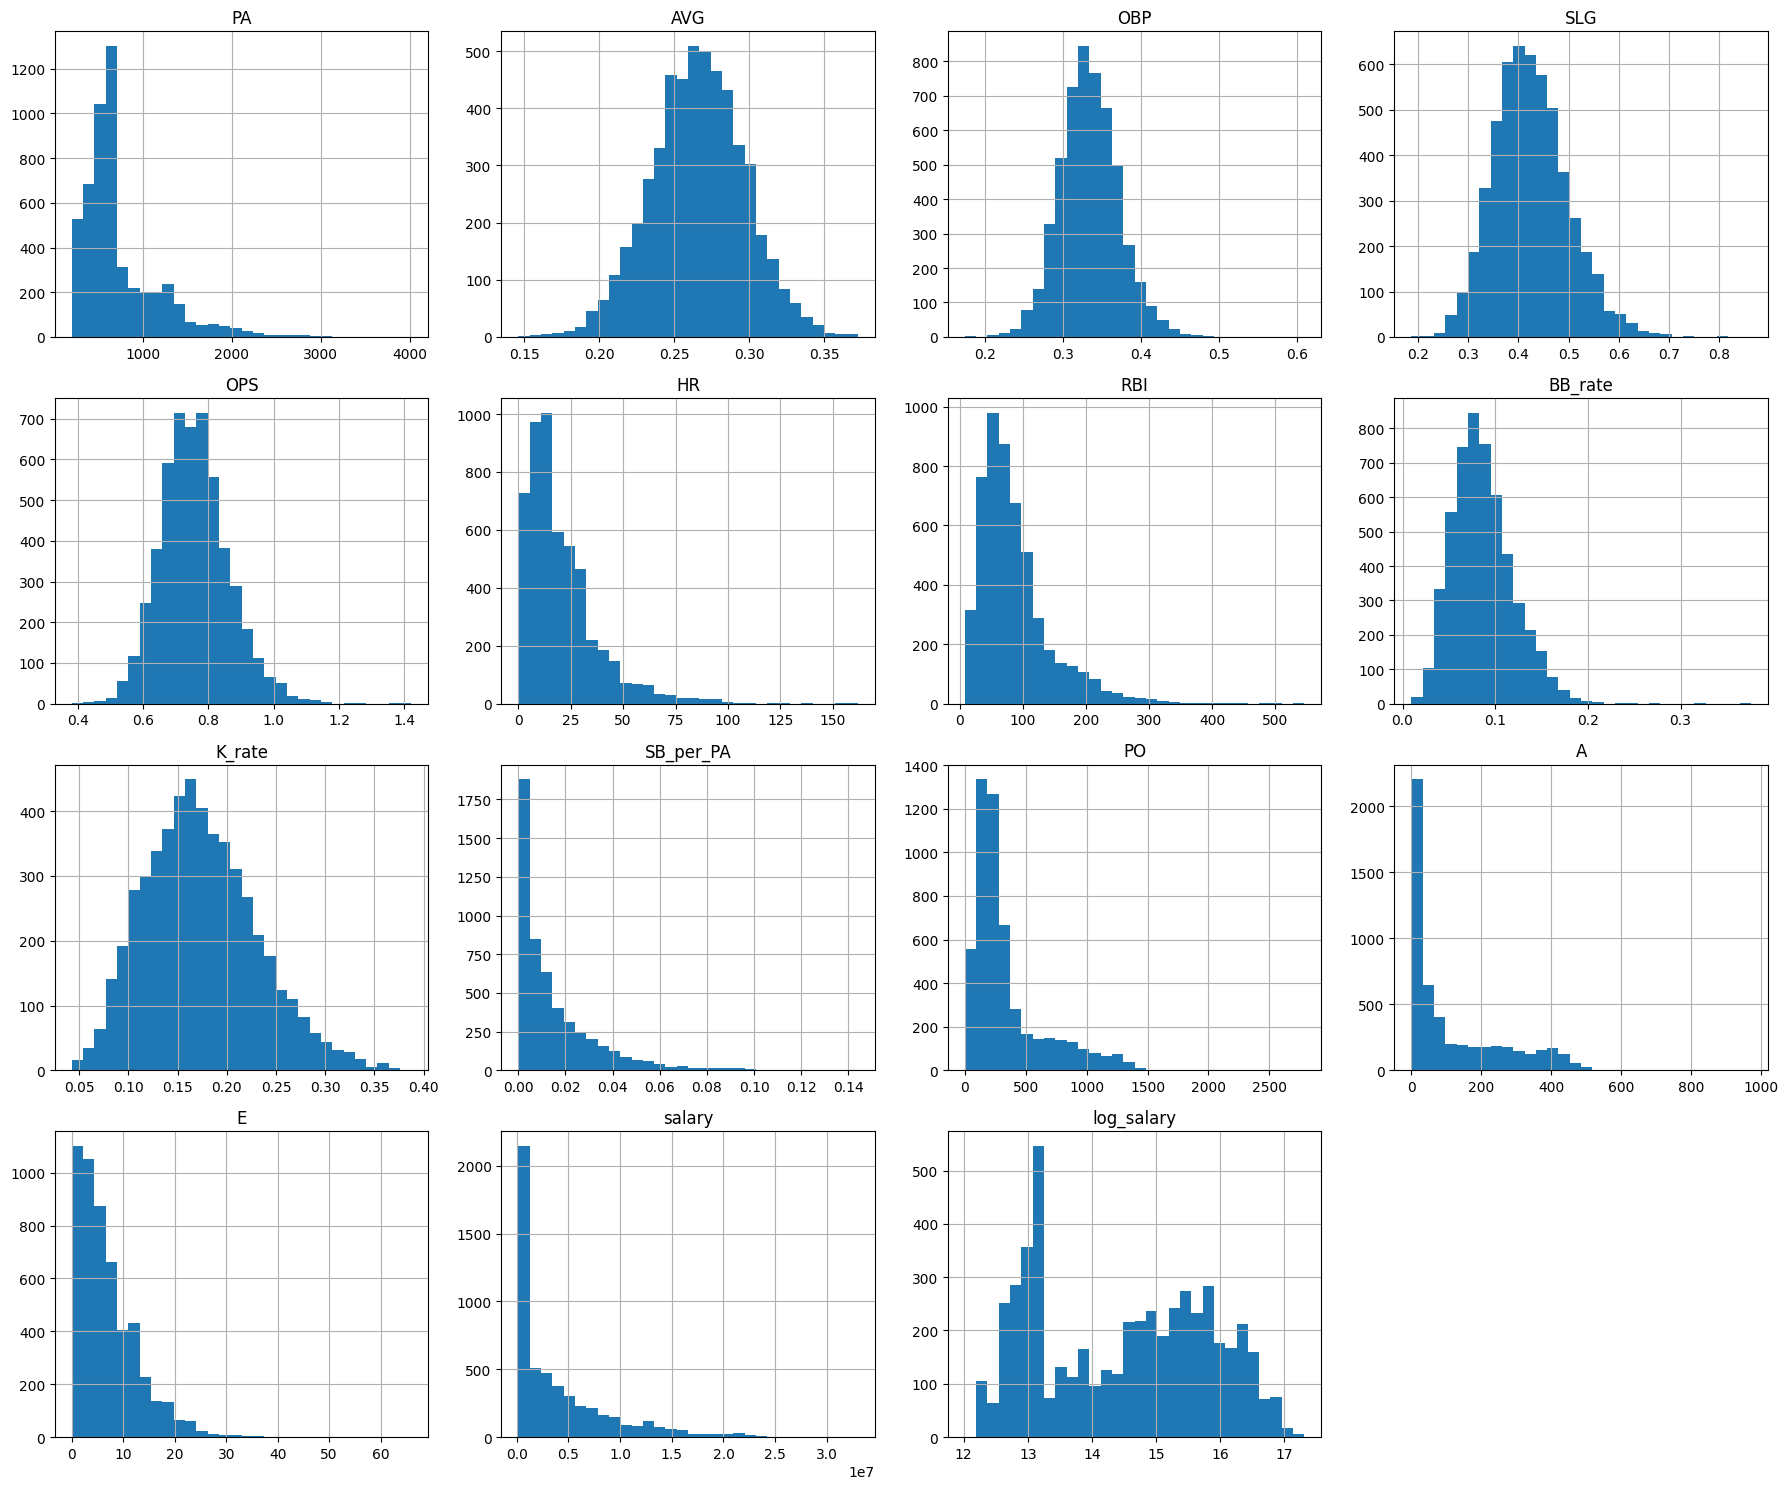

In [28]:
numeric_cols = ['PA', 'AVG', 'OBP', 'SLG', 'OPS', 'HR', 'RBI', 'BB_rate', 'K_rate', 'SB_per_PA', 'PO', 'A', 'E', 'salary', 'log_salary']

agg_df[numeric_cols].hist(figsize=(18, 15), bins=30)
plt.tight_layout()
plt.show()

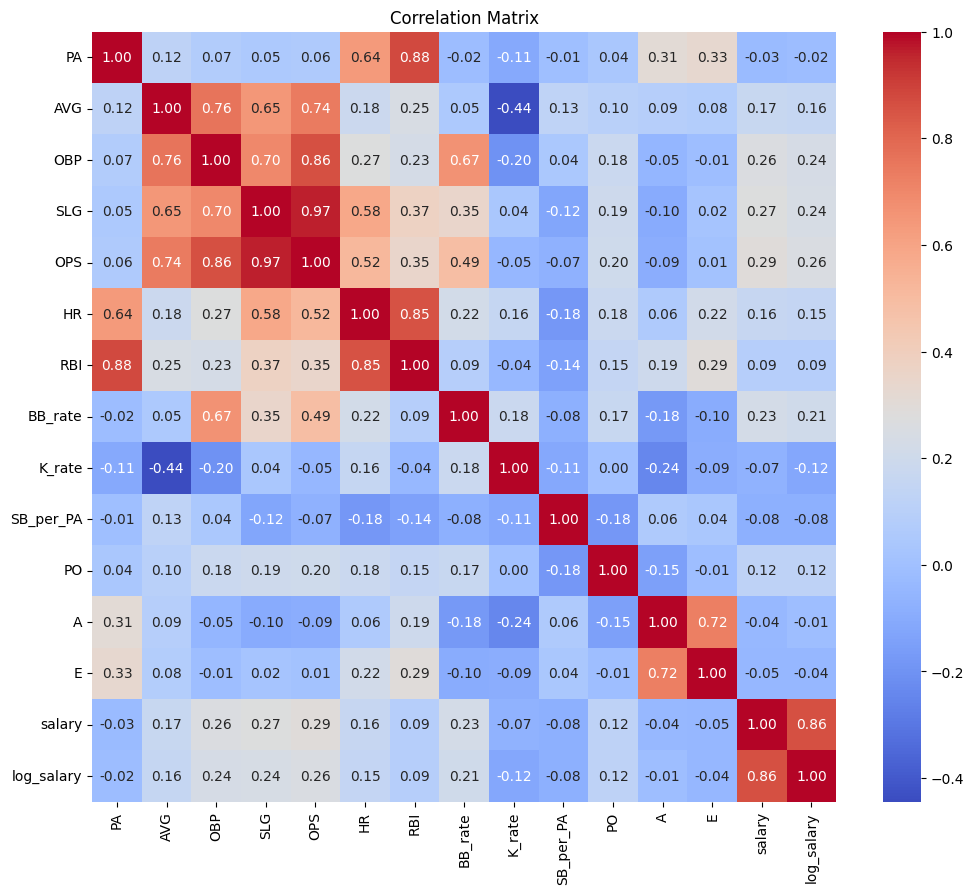

In [29]:
plt.figure(figsize=(12,10))
sns.heatmap(agg_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

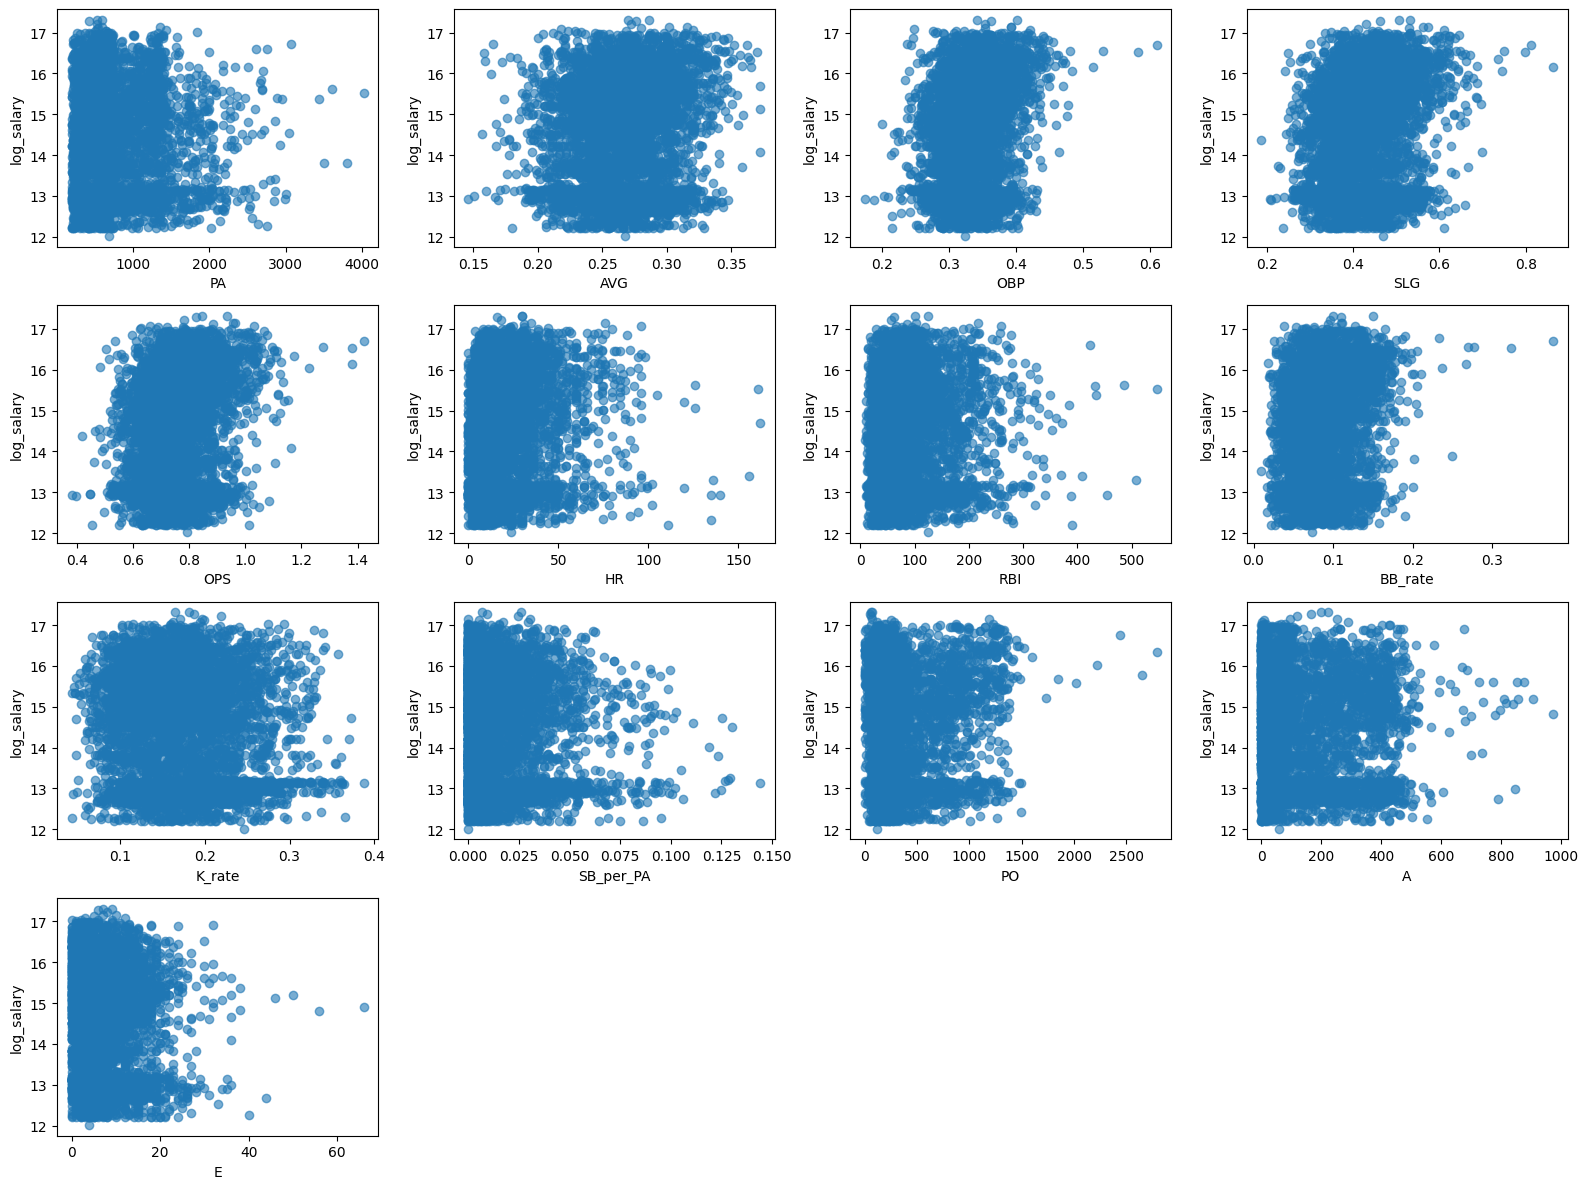

In [30]:
plt.figure(figsize=(16,12))

for i, col in enumerate(['PA','AVG','OBP','SLG','OPS','HR','RBI','BB_rate','K_rate','SB_per_PA','PO','A','E']):
    plt.subplot(4, 4, i+1)
    plt.scatter(agg_df[col], agg_df['log_salary'], alpha=0.6)
    plt.xlabel(col)
    plt.ylabel('log_salary')

plt.tight_layout()
plt.show()

Exploratory data analysis was performed to understand feature distributions, detect outliers, and evaluate correlations. Salary and log-salary distributions revealed significant right-skew, confirming the need for log transformation. Offensive, plate discipline, base-running, and fielding metrics were analyzed for multicollinearity and predictive potential. Analysis confirmed that OPS, OBP, and SLG are highly correlated. All were retained to allow tree-based models to leverage raw rate statistics while linear models could optionally use a reduced set to account for multicollinearity.

## Modeling

In [31]:
# Features
feature_cols = [
    'PA', 'AVG', 'OBP', 'SLG', 'OPS',
    'HR', 'RBI', 'BB_rate', 'K_rate',
    'SB_per_PA', 'PO', 'A', 'E', 'age'
]

X = agg_df[feature_cols]
y = agg_df['log_salary']  # target is log of salary

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    'Linear Regression': LinearRegression(),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        tree_method='hist', 
        random_state=42
    )
}

for name, model in models.items():
    model.fit(X_train, y_train)

Three regression models were trained to predict player salary: linear regression, random forest, and XGBoost. Linear regression serves as a baseline model, while tree-based methods allow for nonlinear relationships and interactions between performance metrics and age. Random forest reduces variance, while XGBoost applies gradient boosting to improve weak learners. Hyperparameters were selected to balance model flexibility and computational efficiency.

Random Forest Feature Importance (Top 10):
      Feature  Importance
13        age    0.477179
4         OPS    0.077529
0          PA    0.065920
10         PO    0.057051
3         SLG    0.047548
11          A    0.045146
8      K_rate    0.035231
9   SB_per_PA    0.032571
7     BB_rate    0.032344
6         RBI    0.029168


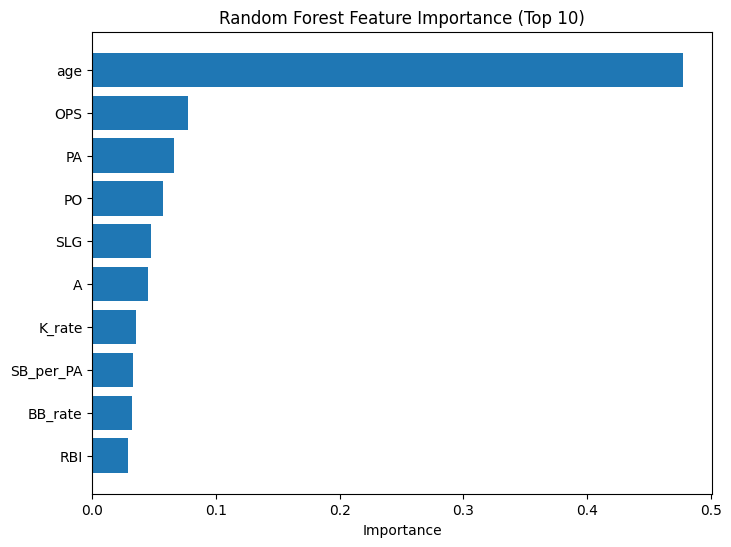

XGBoost Feature Importance (Top 10):
    Feature  Importance
13      age    0.429841
4       OPS    0.085108
3       SLG    0.052618
11        A    0.049937
10       PO    0.048580
5        HR    0.047215
0        PA    0.043341
6       RBI    0.042527
8    K_rate    0.038385
7   BB_rate    0.036159


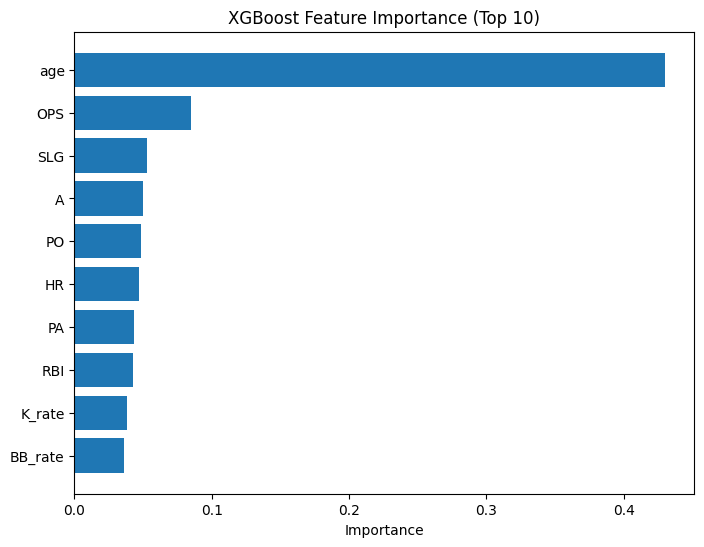

In [33]:
feature_names = X_train.columns

# Random Forest feature importance
rf_importances = models['Random Forest'].feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance (Top 10):")
print(rf_importance_df.head(10))

# Plot
plt.figure(figsize=(8,6))
plt.barh(rf_importance_df['Feature'].head(10)[::-1], rf_importance_df['Importance'].head(10)[::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance (Top 10)")
plt.show()


# XGBoost feature importance
xgb_importances = models['XGBoost'].feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance (Top 10):")
print(xgb_importance_df.head(10))

# Plot
plt.figure(figsize=(8,6))
plt.barh(xgb_importance_df['Feature'].head(10)[::-1], xgb_importance_df['Importance'].head(10)[::-1])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance (Top 10)")
plt.show()

After training, we evaluated which player metrics were most predictive of log salary using Random Forest and XGBoost models. The most significant findings include that age dominates feature importance for both tree-based models, highlighting the premium on experience. Offensive metrics like OPS and SLG are consistently strong predictors. Defensive contributions (PO, A) also play a noticeable role, especially in Random Forest. Rate metrics (K_rate, BB_rate, SB_per_PA) and counting stats (PA, HR, RBI) contribute moderately, suggesting a mix of performance, playing time, and discipline matters for salary predictions.

## Evaluation

--- XGBoost Evaluation ---
RMSE: 0.922
MAE: 0.737
Median AE: 0.631
R^2: 0.510
Max Error: 3.099


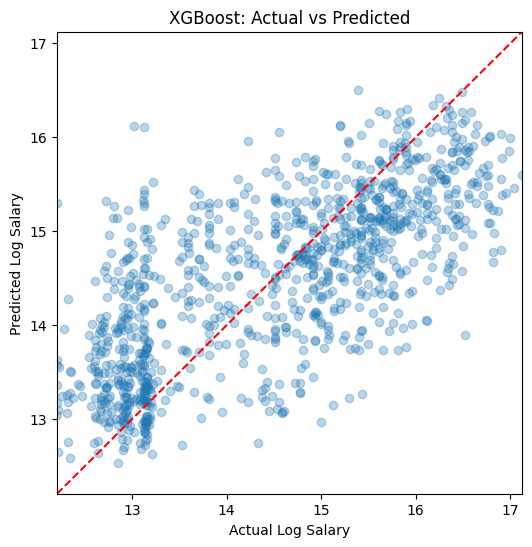

--- Random Forest Evaluation ---
RMSE: 0.935
MAE: 0.744
Median AE: 0.644
R^2: 0.495
Max Error: 3.069


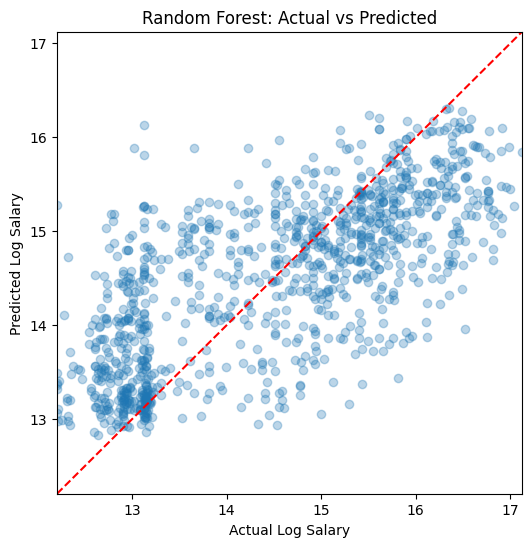

In [34]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, max_error

def evaluate_regression(model, X_test, y_test, model_name= "Model"):
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    max_err = max_error(y_test, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"Median AE: {medae:.3f}")
    print(f"R^2: {r2:.3f}")
    print(f"Max Error: {max_err:.3f}")

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    
    # consistent axis limits
    lims = [
        min(y_test.min(), y_pred.min()),
        max(y_test.max(), y_pred.max())
    ]
    
    # 45-degree reference line
    plt.plot(lims, lims, '--', color='red')
    
    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.xlabel("Actual Log Salary")
    plt.ylabel("Predicted Log Salary")
    plt.title(f"{model_name}: Actual vs Predicted")
    
    plt.show()
        
    return {"RMSE": rmse, "MAE": mae, "MedianAE": medae, "R2": r2, "MaxError": max_err}

xgb_metrics = evaluate_regression(models['XGBoost'], X_test, y_test, model_name="XGBoost")
rf_metrics = evaluate_regression(models['Random Forest'], X_test, y_test, model_name="Random Forest")

In [35]:
def train_test_check(model, X_train, y_train, X_test, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"\n{name}")
    print(f"Train R²: {r2_score(y_train, y_train_pred):.3f}")
    print(f"Test  R²: {r2_score(y_test, y_test_pred):.3f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.3f}")
    print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.3f}")

train_test_check(models['Linear Regression'], X_train, y_train, X_test, y_test, "Linear Regression")
train_test_check(models['Random Forest'], X_train, y_train, X_test, y_test, "Random Forest")
train_test_check(models['XGBoost'], X_train, y_train, X_test, y_test, "XGBoost")


Linear Regression
Train R²: 0.377
Test  R²: 0.351
Train RMSE: 1.049
Test  RMSE: 1.061

Random Forest
Train R²: 0.719
Test  R²: 0.495
Train RMSE: 0.704
Test  RMSE: 0.935

XGBoost
Train R²: 0.718
Test  R²: 0.510
Train RMSE: 0.705
Test  RMSE: 0.922


Train-test comparisons reveal that linear regression underfits the data, displaying low explanatory power on both the training and test sets. Tree-based models substantially improve predictive performance. While Random Forest and XGBoost show higher training R² values, their test performance remains strong, showing controlled overfitting. XGBoost achieves the highest test R² and lowest RMSE, suggesting the best balance between bias and variance.

## Discussion

Our analysis aimed to predict MLB player salaries (log-transformed) using a combination of offensive, defensive, and contextual features. The results reveal several key insights:

### 1. Model Performance
- **Linear Regression** underfits the data, with low training and test R², indicating it cannot capture complex non-linear relationships in salary determination.
- **Tree-based models** (Random Forest and XGBoost) substantially improve predictive performance:
  - Test R² ≈ 0.50  
  - RMSE ≈ 0.92–0.94  
  - XGBoost slightly outperforms Random Forest, capturing subtle interactions among features.

### 2. Feature Importance Insights
- **Age** is the dominant predictor, emphasizing the value of experience and body of work.
- **Offensive metrics** like OPS and SLG strongly influence salary.
- **Defensive contributions** (PO, A) also impact salaries, particularly in Random Forest.
- **Rate stats** (K_rate, BB_rate, SB_per_PA) and **counting stats** (PA, HR, RBI) provide moderate contributions, showing the combined influence of skill efficiency, playing time, and traditional stats.

### 3. Underfitting and Overfitting Checks
- Tree-based models show controlled overfitting: high training R² (~ 0.72) vs. lower test R² (~ 0.50).  
- Linear Regression consistently underfits, indicating linear assumptions are insufficient.

### 4. Practical Implications
- Teams and analysts can leverage these models to understand which performance metrics drive salaries.  
- **Age and OPS** are critical, highlighting the importance of experience combined with offensive production.  
- Defensive metrics remain relevant, particularly for positions with high fielding demands.

### 5. Limitations and Next Steps
- Salaries are log-transformed and not adjusted for inflation, which may slightly distort era comparisons.  
- Future work could explore:
  - Advanced feature engineering (e.g., position-adjusted metrics)
  - Temporal salary trends
  - Hyperparameter tuning and ensemble methods to improve accuracy

### Conclusion
Tree-based models effectively capture the key drivers of MLB salaries. Experience (age) and offensive output (OPS, SLG) are the most critical factors, with defensive contributions and rate metrics providing nuanced adjustments. These insights can guide salary projections, player evaluations, and understanding market dynamics in professional baseball.